In [1]:
from scripts import support, insd, kuroda, nras, metrics, vectorization as v
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# Load base matrix
df = pd.read_excel("./data/tri-2011.xlsx", 'ТИоц', skiprows=2, index_col=1)
df = df.iloc[1:63, 2:-13].astype(np.float)
# df = df.drop(columns=df.columns[[-11, -6, -2]])
df_shape = df.shape

# Load predicted matrix
pred_df = pd.read_excel("./data/tri-2016.xlsx", 'ТИоц', skiprows=2, index_col=1)
pred_df = pred_df.iloc[1:63, 2:-13].astype(np.float)
# pred_df = pred_df.drop(columns=pred_df.columns[[-11, -6, -2]])

df.shape, pred_df.shape

((62, 59), (62, 59))

In [3]:
# cols_to_agg = [['P31_S13', 'P32_S13'],
#                ['P51', 'P53']]
# new_cols = ['P3_S13',
#             'P51+P53']

# for i in range(len(new_cols)):
#     df.insert(int(np.argwhere(np.array(df.columns) == cols_to_agg[i][0])[0, 0]), 
#                    new_cols[i], np.sum(df[cols_to_agg[i]], axis=1))
#     df = df.drop(columns=cols_to_agg[i])

#     pred_df.insert(int(np.argwhere(np.array(pred_df.columns) == cols_to_agg[i][0])[0, 0]), 
#                         new_cols[i], np.sum(pred_df[cols_to_agg[i]], axis=1))
#     pred_df = pred_df.drop(columns=cols_to_agg[i])

# df_shape = pred_df.shape
# df.shape, pred_df.shape

In [39]:
df.head()

,01,02,05,10,11,12,13,14,15,16,...,73,74,75,80,85,90,91,92,93,95
Коды,,,,,,,,,,,,,,,,,,,,,
01,702865.0,634.0,409.0,3.0,165.0,0.0,5.0,98.0,1306004.0,34676.0,...,1163.0,710.0,33688.0,5200.0,18044.0,116.0,634.0,1323.0,3107.0,0.0
02,883.0,15112.0,1.0,136.0,113.0,0.0,18.0,14.0,326.0,0.0,...,16.0,62.0,5586.0,166.0,215.0,12.0,18.0,140.0,112.0,0.0
05,64.0,0.0,4639.0,0.0,0.0,0.0,1.0,0.0,72672.0,0.0,...,77.0,11.0,643.0,13.0,311.0,1.0,32.0,97.0,0.0,0.0
10,1689.0,9.0,53.0,96308.0,427.0,6.0,371.0,147.0,1837.0,0.0,...,42.0,235.0,3026.0,760.0,2426.0,147.0,22.0,202.0,217.0,0.0
11,212.0,0.0,0.0,294.0,239950.0,0.0,0.0,167.0,84.0,0.0,...,6.0,3797.0,0.0,0.0,10.0,2.0,0.0,0.0,0.0,0.0


In [40]:
# Sums of rows\columns
sums_rows = pred_df.sum(axis=1).values.reshape(-1, 1)
sums_cols = pred_df.sum(axis=0).values.reshape(-1, 1)

# Vectorization of matrixa
vect_a = v.tovector(df.values)
vect_a

array([[7.02865e+05],
       [8.83000e+02],
       [6.40000e+01],
       ...,
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00]])

In [41]:
sums_rows.shape, sums_cols.shape

((62, 1), (59, 1))

In [42]:
# Merge column of constraints
c = np.append(sums_rows, sums_cols, axis=0)
print(c.shape)

# Create matrix G of coefficients of constraints 
G = v.addrows(df_shape, sparsed=True) # Use "sparsed" parameter everywhere if want use fast sparsed matrix
G = v.addcolumns(df_shape, G, sparsed=True) # Use "sparsed" parameter everywhere if want use fast sparsed matrix
G.toarray()

(121, 1)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [43]:
G.shape

(121, 3658)

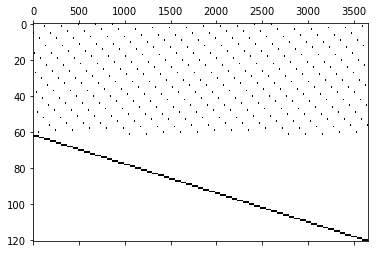

In [44]:
# Look on the distribution of 0s and 1s in matrix of coefficients G
plt.spy(G.toarray(), aspect='auto')

In [45]:
# Run method of projection - NRAS(~181 ms) and got metrics and result matrix 
res_df = nras.nras(G=G, aa=vect_a, c=c, accuracy=0.001, limit = 1000, sparsed=True)
simple_metics = pd.DataFrame.from_dict({2011: metrics.get_values(res_df, pred_df.values, save=True, shape=df_shape)}, orient='index')
simple_metics

,N0,PSISTAT,RSQ,MAPE,SWAD,WAPE
2011,450,0.0142,0.9806,100.0215,0.0935,15.6903


In [46]:
simple_metics.index[0]

2011

In [47]:
# Create matrix G of coefficients of constraints 
G = v.addrows(df_shape, sparsed=True)
G = v.addcolumns(df_shape, G, sparsed=True) 

def apply_method(initial_est, true_table, method=nras.nras):        
    sums_rows = true_table.sum(axis=1).reshape(-1, 1)
    sums_cols = true_table.sum(axis=0).reshape(-1, 1)
    c = np.append(sums_rows, sums_cols, axis=0)

    vect_a = v.tovector(initial_est)

    pred_table = method(G=G, aa=vect_a, c=c, accuracy=0.001, limit=1000, sparsed=True)
    
    return v.tomatrix(pred_table, shape=df_shape)

In [48]:
def get_metrics_for_series(true_tables, pred_tables):
    start_year = list(true_tables.keys())[0]
    final_year = list(true_tables.keys())[-1]

    for y in range(start_year + 1, final_year + 1):
        true_table_y = true_tables[y]
        pred_table_y = pred_tables[y]
        
        res_metrics = metrics.get_values(pred_table_y, true_table_y, save=True)
        if y == start_year + 1:
            constr_metrics = pd.DataFrame.from_dict({y: res_metrics}, orient='index')
        else:
            constr_metrics = pd.concat((constr_metrics, 
                                        pd.DataFrame.from_dict({y: res_metrics}, orient='index')), 
                                       axis=0)
        
    return constr_metrics

## Time series SUTs for RU 2011-2016

In [49]:
years = np.arange(2011, 2017)

true_tables = dict.fromkeys(years)
true_tables[2011] = df.values
true_tables[2016] = pred_df.values

In [50]:
for y in years[1:-1]:
    true_table = pd.read_excel('./data/tri-' + str(y) + '.xlsx', 'ТИоц', skiprows=2, index_col=1)
    true_table = true_table.iloc[1:63, 2:-11].astype(np.float)    
#     true_table = true_table.drop(columns=true_table.columns[[-11, -7, -4, -2, -1]])
    true_tables[y] = true_table.values
    print(y, true_table.shape)

2012 (62, 59)
2013 (62, 59)
2014 (62, 59)
2015 (62, 59)


In [51]:
true_tables[2011]

array([[7.02865e+05, 6.34000e+02, 4.09000e+02, ..., 1.32300e+03,
        3.10700e+03, 0.00000e+00],
       [8.83000e+02, 1.51120e+04, 1.00000e+00, ..., 1.40000e+02,
        1.12000e+02, 0.00000e+00],
       [6.40000e+01, 0.00000e+00, 4.63900e+03, ..., 9.70000e+01,
        0.00000e+00, 0.00000e+00],
       ...,
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [52]:
def construct_time_series(true_tables):        
    start_year = list(true_tables.keys())[0]
    final_year = list(true_tables.keys())[-1]
    
    time_series = np.array([true_tables[start_year]])
    
    table_y = true_tables[start_year]
    
    for y in np.arange(start_year + 1, final_year + 1):
        true_table_y = true_tables[y]
        
        table_y = apply_method(table_y, true_table_y)        
        time_series = np.vstack((time_series, [table_y]))
        
    return dict(zip(np.arange(start_year, final_year + 1), time_series))        

In [53]:
time_series = construct_time_series(true_tables)
time_series[2011].shape

(62, 59)

In [54]:
metrics_nras = get_metrics_for_series(true_tables, time_series)
metrics_nras

,N0,PSISTAT,RSQ,MAPE,SWAD,WAPE
2012,390,0.0025,0.9978,11.3910,0.0249,6.0148
2013,383,0.0045,0.9953,17.2912,0.0437,8.5321
2014,378,0.0059,0.9936,28.1549,0.0553,9.8512
2015,379,0.0077,0.9908,33.5651,0.0657,11.2137
2016,450,0.0142,0.9806,100.0215,0.0935,15.6903


 ## Cycling method

$alpha = 1 \Rightarrow$ the initial estimate is always and only taken from the same-year solution of the prior cycle

$alpha = 0 \Rightarrow$ the initial estimate ignores any prior cycle and only ever considers same-cycle, prior-year values

In [55]:
def cycling_method(true_tables, max_cycles, alpha=0.5, eps=0.01):
    start_year = list(true_tables.keys())[0]
    final_year = list(true_tables.keys())[-1]
    
    a = np.expand_dims(list(construct_time_series(true_tables).values()), 0)
    a[0, -1] = true_tables[final_year]
    
    w = np.array([[0, alpha], [1 - alpha, 0]])
    
    tables_shape = true_tables[start_year].shape
    
    true_tables_arr = np.array(list(true_tables.values()))
    
    y = final_year - start_year
    for c in range(1, max_cycles):
        print('cycle no:', c)
        
        a_c = np.zeros((1, final_year - start_year + 1, tables_shape[0], tables_shape[1]))
        a_c[0, 0] = true_tables[start_year]
        a_c[0, -1] = true_tables[final_year]
        a = np.vstack((a, a_c))
        
        for i in range(final_year - start_year - 1):
            increment = 1 if c % 2 == 0 else -1
            y = y + increment
            initial_est = w[0, 0] * a[c, y] + w[0, 1] * a[c, y - increment] + \
                          w[1, 0] * a[c - 1, y] + w[1, 1] * a[c - 1, y - increment]
            a[c, y] = apply_method(initial_est, true_tables_arr[y])
        
        a_avg = np.average(a[-2:], axis=0)   
        if np.average(np.abs(a[c - 1] - a[c]) / a[c - 1]) < eps:
            break
        
        y = y + increment
        
    return dict(zip(np.arange(start_year, final_year + 1), a_avg))

In [56]:
time_series_cyc = cycling_method(true_tables, 10)
time_series_cyc[2011].shape

cycle no: 1
cycle no: 2
cycle no: 3
cycle no: 4
cycle no: 5
cycle no: 6
cycle no: 7
cycle no: 8
cycle no: 9


(62, 59)

In [57]:
metrics_nras_cyc = get_metrics_for_series(true_tables, time_series_cyc).iloc[:-1]
metrics_nras_cyc

,N0,PSISTAT,RSQ,MAPE,SWAD,WAPE
2012,390,0.0023,0.9979,16.4534,0.0273,5.7558
2013,383,0.0038,0.9960,25.5525,0.0420,7.9099
2014,378,0.0044,0.9962,37.2006,0.0381,8.3011
2015,379,0.0048,0.9967,43.5134,0.0303,8.3529


## Compare results

In [58]:
metrics_names = list(simple_metics.keys())
metrics_names

['N0', 'PSISTAT', 'RSQ', 'MAPE', 'SWAD', 'WAPE']

In [59]:
metrics_res_dict = {#'1 nras to target year': simple_metics, 
                    '2 year-by-year nras': metrics_nras.iloc[:-1, :],
                    '3 cycling nras': metrics_nras_cyc}

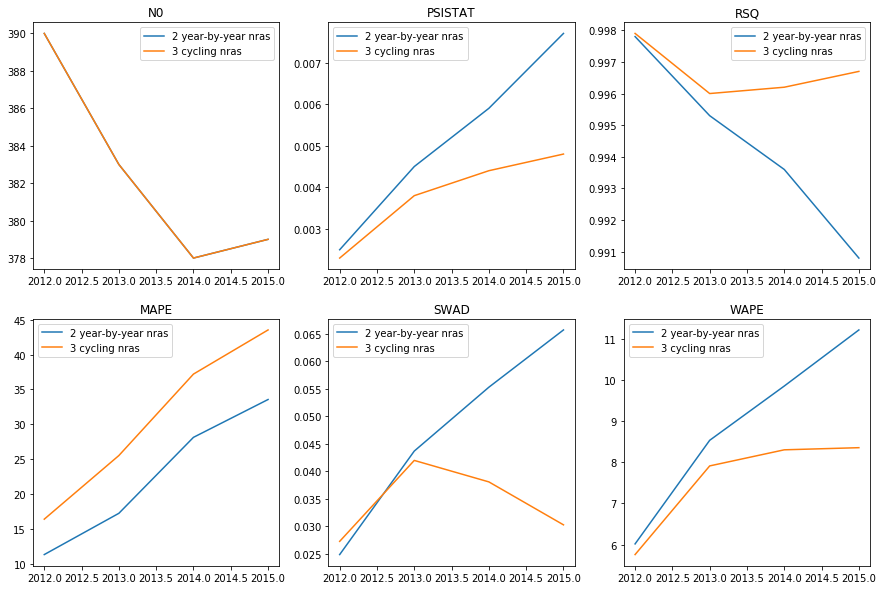

In [60]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
 
ind = 0
for i in range(ax.shape[0]):    
    for j in range(ax.shape[1]):        
        for method, metrics_res in metrics_res_dict.items():
            if method == '1 nras to target year':
                ax[i, j].scatter(2016, metrics_res[metrics_names[ind]], label=method)
            else:
                ax[i, j].plot(metrics_res[metrics_names[ind]], label=method)
                
        ax[i, j].set_title(metrics_names[ind])
        ax[i, j].legend()
        ind += 1
        
plt.show()

## MTT II method

In [25]:
from sklearn.linear_model import LinearRegression as lr

In [26]:
def transform_mtt2(true_tables_arr):    
    transformed_tables = np.zeros((true_tables_arr.shape[0], 
                                   true_tables_arr.shape[1] - 1, 
                                   true_tables_arr.shape[2] - 1), dtype='float')
    
    for i in range(true_tables_arr.shape[0]):
        u = true_tables_arr[i, :-1, :-1]
        u = u / np.repeat(true_tables_arr[i, :-1, -1:], u.shape[1], axis=1)
        
        transformed_tables[i] = u
    
    return transformed_tables

In [27]:
z = np.array([[[1, 2, 3], 
               [4, 5, 6],
               [7, 8, 9]], 
              [[10, 11, 12], 
               [13, 14, 15],
               [16, 17, 18]],
              [[19, 20, 21],
               [22, 23, 24],
               [25, 26, 27]]])
u = transform_mtt2(z)
u == np.array([[[1/3, 2/3],
                [4/6, 5/6]],
               [[10/12, 11/12],
                [13/15, 14/15]],
               [[19/21, 20/21],
                [22/24, 23/24]]])

array([[[ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True]]])

In [28]:
def inverse_transform_mtt2(f, u):
    x = np.zeros((u.shape[0], u.shape[1] + 1), dtype='float')
    
    for j in range(u.shape[0]):
        for k in range(u.shape[1]):
            x[j, k] = u[j, k] * f[j] / (1 + np.sum(u[j]))
        x[j, -1] = f[j] / (1 + np.sum(u[j]))  
                           
    return x

In [29]:
# x = inverse_transform_mtt2(z, u)
# x

In [30]:
def mtt2(true_tables, intermediate_shape):
    start_year = list(true_tables.keys())[0]
    final_year = list(true_tables.keys())[-1]
    
    true_tables_arr = np.array(list(true_tables.values()))
    
    tables_shape = true_tables[start_year].shape
    
    u_base = transform_mtt2(true_tables_arr[:2, : intermediate_shape[0], : intermediate_shape[1]])
    
    f = np.full_like(u_base[0], lr(), dtype=lr)
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            x = np.array([[1], [2]])
            y = np.array([u_base[0][i, j], u_base[1][i, j]])
            f[i, j].fit(x, y)
            
    pred_tables_arr = np.zeros((true_tables_arr.shape[0], intermediate_shape[0] + 1, intermediate_shape[1] + 1), dtype='float')
    pred_tables_arr[:2] = true_tables_arr[:2]

    for i in range(2, pred_tables_arr.shape[0]):
        u = np.zeros_like(u_base[0], dtype='float')
        for j in range(u_base.shape[1]):
            for k in range(u_base.shape[2]):
                u[j, k] = f[j, k].predict(i)
                        
        intermediate_out = np.sum(true_tables_arr[i, : intermediate_shape[0], : intermediate_shape[1]], axis=0)
        intermediate_in = np.sum(true_tables_arr[i, : intermediate_shape[0]:, : intermediate_shape[1]], axis=1)
        gross_out = np.sum(true_tables_arr[i, :, : intermediate_shape[1]], axis=0)
        
        pred_tables_arr[i, : u.shape[0], : u.shape[1] + 1] = inverse_transform_mtt2(intermediate_out, u)

        pred_tables_arr[i, intermediate_shape[0] - 1, : intermediate_shape[1]] = intermediate_out - np.sum(pred_tables_arr[i, :, : intermediate_shape[1]], axis=0)

        pred_tables_arr[i, intermediate_shape[0],  : intermediate_shape[1]] = gross_out - intermediate_out
        pred_tables_arr[i, : intermediate_shape[0], intermediate_shape[1]] = gross_out - intermediate_in
        pred_tables_arr[i, -1, -1] = np.sum(pred_tables_arr[i, -1])
                
    return dict(zip(np.arange(start_year, final_year + 1), pred_tables_arr))

In [31]:
mtt2(dict(zip([1, 2, 3], np.array([np.full((4, 4), 1), np.full((4, 4), 2), np.full((4, 4), 3)]))), (3, 3))

{1: array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]), 2: array([[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]]), 3: array([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 9.]])}

## Time series IOTs for RU